# Offline diagnostics for single output networks following Rasp et al. (2018) architecture

# Selected Inputs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata
from utils.constants import SPCAM_Vars
from utils.plotting import plot_matrix, plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Setup

In [6]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001/") 
# cfg = os.path.join(base_dir, "cfg_pre_mask_net.yml")


# training_74_pre_mask_net_spars0.001

# training_88_mask_net_prediction_thresholds_spars1.0
# training_89_mask_net_prediction_thresholds_spars0.1
# training_90_mask_net_prediction_thresholds_spars0.01
# training_91_mask_net_prediction_thresholds_spars0.001
# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

# "training_95_mask_net_prediction_thresholds_spars1.0"
# "training_96_mask_net_prediction_thresholds_spars0.1"
# "training_97_mask_net_prediction_thresholds_spars0.01"
# "training_98_mask_net_prediction_thresholds_spars0.001"
# "training_99_mask_net_prediction_thresholds_spars1e-4"
# "training_100_mask_net_prediction_thresholds_spars1e-5"

# training_103_mask_net_prediction_thresholds_spars0.001_plus4k
# training_104_mask_net_prediction_thresholds_spars0.001_minus4k
# training_105_mask_net_prediction_thresholds_spars0.001_plus4k_ref
# training_106_mask_net_prediction_thresholds_spars0.001_minus4k_ref

base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_91_mask_net_prediction_thresholds_spars0.001") 
train_val = "train"

pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001")
masking_vector_dir = os.path.join(pre_mask_net_dir, "masking_vectors")








In [7]:
def get_cfg_and_threshold_dir(b_dir, train_or_val):
    if "prediction_thresholds" in b_dir: 
        cfg = os.path.join(b_dir, f"cfg_mask_net_thresholds_{train_or_val}.yml")
        threshold_dir = os.path.join(b_dir, "threshold_performance") 
    else: 
        cfg = os.path.join(b_dir, "cfg_mask_net.yml")
        threshold_dir = os.path.join(bab_dirse_dir, "bespoke_thresholds")
    return cfg, threshold_dir


In [8]:

def get_outputs_map_file(b_dir, train_or_val):
    if "prediction_thresholds" in Path(b_dir).name:
        shap_dict_dir = Path(b_dir, "plots_offline_evaluation", f"shap_{train_or_val}", "range-all_samples-1000_all")
    else:
        shap_dict_dir = Path(b_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
    outputs_map_file = Path(b_dir, "outputs_map.txt")

    return outputs_map_file

In [9]:
def get_setup(cfg_file):
    argv  = ["-c", cfg_file]
    return SetupDiagnostics(argv)

## Get Masking Vectors

In [10]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [11]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [22]:
def get_masking_vector(mv_dir, setup):
    output_vars = generate_output_vars(setup)
    
    masking_vector_per_var = dict()
    for var in output_vars: 
        masking_vector = np.load(os.path.join(mv_dir, f"masking_vector_{var}.npy"))
        masking_vector_per_var[var] = masking_vector
    print(f"Loaded masking vector from {mv_dir}")

    return masking_vector_per_var

## Get Thresholds

In [13]:
def load_thresholds_per_var(b_dir, t_dir, train_or_val):
    if "prediction_thresholds" in b_dir: 
        f_name = f"threshold_per_var_{train_or_val}.p"
    else: 
        f_name = "thresholds_per_var.p"
    
    with open(os.path.join(t_dir, f_name), "rb") as in_file:
         t_per_var = pickle.load(in_file)

    return t_per_var
    

In [24]:
def get_thresholded_masking_vector_per_var(thresholds_per_var, mv_per_var, setup):
    td_mv_per_var = dict()
    output_vars = generate_output_vars(setup)
    
    for var in output_vars:
        t = thresholds_per_var[var]
        masking_vector = mv_per_var[var]
        
        t_vector = np.where(masking_vector < t, 
                            np.zeros_like(masking_vector, dtype=int), # value if condition true 
                            np.ones_like(masking_vector, dtype=int)) # value if condition false
        
        td_mv_per_var[var] = t_vector

    return td_mv_per_var

## Get Inputs Matrix

In [15]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [16]:
def calculate_input_matrix(setup, inputs_per_var):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)

    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    inputs_matrix = np.ma.zeros([len(output_vars), len(input_vars)], dtype=int)
    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue

        if setup.nn_type == "MaskNet":
            var_inputs_idx = np.flatnonzero(inputs_per_var[var])
        else: 
            var_inputs_idx = inputs_per_var[var]

        inputs_per_var

        for k in range(num_inputs):
            j = input_inverse_idx[k]

            # print(k)
            # print(j)
            # Check if this input is an input for the current variables
            try:
                inputs_matrix[i, k] = inputs_per_var[var][j]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return inputs_matrix, input_inverse_idx2var, output_vars


## Plot

In [30]:
def plot_matrix_shap(input_dict_inv_remap_var, dict_outputs_idxs, input_matrix, 
                     second_matrix=None, labels=None, f_name="", 
                     diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', **kwargs):
    # diff doesn't do anything
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs)



    # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=input_matrix.max(), base=10)
    if not cmap: cmap='Blues'
    if not extend: extend='max'
    cbar_label=''
            
   
    fig, ax = plot_matrix(None, input_matrix,
                          in_vars, in_box_idx, in_ticks, in_ticks_labs,
                          out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                          extend, cbar_label, mask=False, num_parents=None,
                          # vmin=vmin,
                          # vmax=vmax,
                          cmap=cmap,
                          # norm=colors.CenteredNorm(),
                          # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                          # norm=norm,
                          interpolation=interpolation, 
                          second_matrix=second_matrix, 
                          labels=labels
                          )
    ax.set_rasterized(True)
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        fig.savefig(os.path.join(save, f"{f_name}.pdf"), format="pdf", bbox_inches="tight", transparent=True)
        fig.savefig(os.path.join(save, f"{f_name}.png") ,dpi=600.,bbox_inches='tight', transparent=True)
        
        print(f"Saved input matrix {save}/{f_name}.pdf/png")
    return fig, ax

## Reference climate

In [20]:
ref_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_91_mask_net_prediction_thresholds_spars0.001") 
train_val = "train"

ref_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001")
ref_masking_vector_dir = os.path.join(ref_pre_mask_net_dir, "masking_vectors")

ref_output_dir = os.path.join(ref_base_dir, "plots_offline_evaluation", "inputs")

In [25]:
ref_cfg, ref_threshold_dir = get_cfg_and_threshold_dir(ref_base_dir, train_val)

ref_setup = get_setup(ref_cfg)
ref_mv_per_var = get_masking_vector(ref_masking_vector_dir, ref_setup)

ref_thresholds_per_var = load_thresholds_per_var(ref_base_dir, ref_threshold_dir, train_val)

ref_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(ref_thresholds_per_var, ref_mv_per_var, ref_setup)


Set leaky relu alpha to 0.3

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_74_pre_mask_net_spars0.001/masking_vectors


In [26]:
ref_input_matrix, ref_input_inverse_idx2var, ref_output_vars_idx = calculate_input_matrix(ref_setup, 
                                                                                          ref_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/inputs/inputs_0k_mask_net.pdf/png


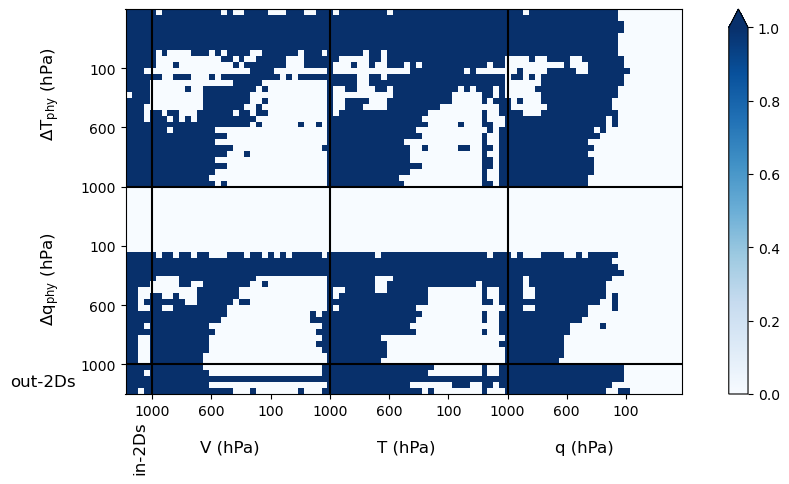

In [31]:
plot_name = "inputs_0k_mask_net"
fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, ref_input_matrix,
                           cmap="Blues", f_name=plot_name, save=ref_output_dir)

# plt.savefig(os.path.join(ref_output_dir, f"{plot_name}.pdf"), format="pdf", bbox_inches="tight")

# fig.show()


## +4K climate

In [32]:
plus4k_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_103_mask_net_prediction_thresholds_spars0.001_plus4k") 

plus4k_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_101_pre_mask_net_spars0.001_plus4k")
plus4k_masking_vector_dir = os.path.join(plus4k_pre_mask_net_dir, "masking_vectors")

plus4k_output_dir = os.path.join(plus4k_base_dir, "plots_offline_evaluation", "inputs")

In [33]:
plus4k_cfg, plus4k_threshold_dir = get_cfg_and_threshold_dir(plus4k_base_dir, train_val)

plus4k_setup = get_setup(plus4k_cfg)
plus4k_mv_per_var = get_masking_vector(plus4k_masking_vector_dir, plus4k_setup)

plus4k_thresholds_per_var = load_thresholds_per_var(plus4k_base_dir, plus4k_threshold_dir, train_val)

plus4k_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(plus4k_thresholds_per_var, plus4k_mv_per_var, plus4k_setup)


Set leaky relu alpha to 0.3

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_101_pre_mask_net_spars0.001_plus4k/masking_vectors


In [34]:
plus4k_input_matrix, plus4k_input_inverse_idx2var, plus4k_output_vars_idx = calculate_input_matrix(plus4k_setup, 
                                                                                                   plus4k_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_103_mask_net_prediction_thresholds_spars0.001_plus4k/plots_offline_evaluation/inputs/inputs_plus4k_mask_net.pdf/png


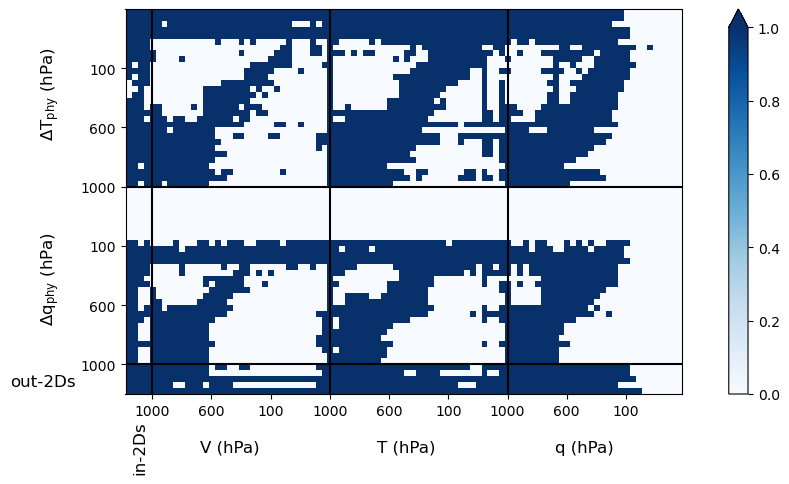

In [35]:
plot_name = "inputs_plus4k_mask_net"

fig, ax = plot_matrix_shap(plus4k_input_inverse_idx2var, plus4k_output_vars_idx, plus4k_input_matrix,
                           cmap="Blues", f_name=plot_name, save=plus4k_output_dir)

# plt.savefig(os.path.join(plus4k_output_dir, f"{plot_name}.pdf"), format="pdf", bbox_inches="tight")
# fig.show()


## -4K climate

In [36]:
minus4k_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_104_mask_net_prediction_thresholds_spars0.001_minus4k") 

minus4k_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_102_pre_mask_net_spars0.001_minus4k")
minus4k_masking_vector_dir = os.path.join(minus4k_pre_mask_net_dir, "masking_vectors")

minus4k_output_dir = os.path.join(minus4k_base_dir, "plots_offline_evaluation", "inputs")

In [37]:
minus4k_cfg, minus4k_threshold_dir = get_cfg_and_threshold_dir(minus4k_base_dir, train_val)

minus4k_setup = get_setup(minus4k_cfg)
minus4k_mv_per_var = get_masking_vector(minus4k_masking_vector_dir, minus4k_setup)

minus4k_thresholds_per_var = load_thresholds_per_var(minus4k_base_dir, minus4k_threshold_dir, train_val)

minus4k_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(minus4k_thresholds_per_var, minus4k_mv_per_var, minus4k_setup)


Set leaky relu alpha to 0.3

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_102_pre_mask_net_spars0.001_minus4k/masking_vectors


In [38]:
minus4k_input_matrix, minus4k_input_inverse_idx2var, minus4k_output_vars_idx = calculate_input_matrix(minus4k_setup, 
                                                                                                      minus4k_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_104_mask_net_prediction_thresholds_spars0.001_minus4k/plots_offline_evaluation/inputs/inputs_minus4k_mask_net.pdf/png


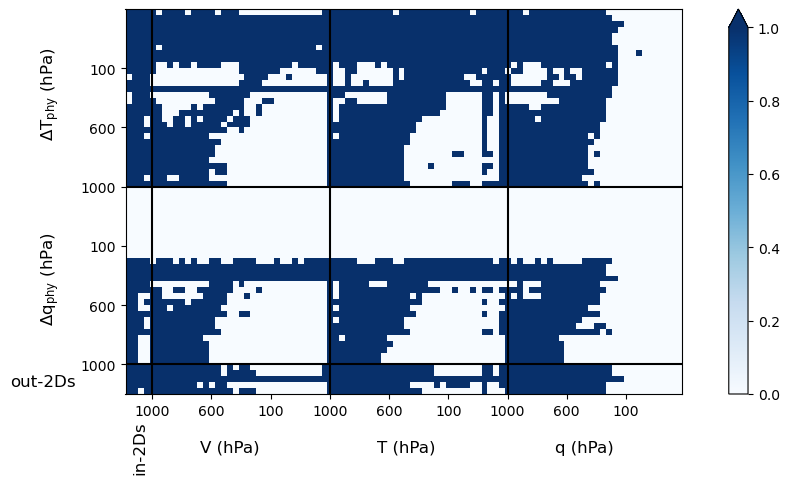

In [39]:
plot_name = "inputs_minus4k_mask_net"

fig, ax = plot_matrix_shap(minus4k_input_inverse_idx2var, minus4k_output_vars_idx, minus4k_input_matrix,
                           cmap="Blues", f_name=plot_name, save=minus4k_output_dir)

# plt.savefig(os.path.join(minus4k_output_dir, f"{plot_name}.pdf"), format="pdf", bbox_inches="tight")
# fig.show()


## Overlay reference with +4K

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/inputs/inputs_ref_plus4k_mask_net.pdf/png


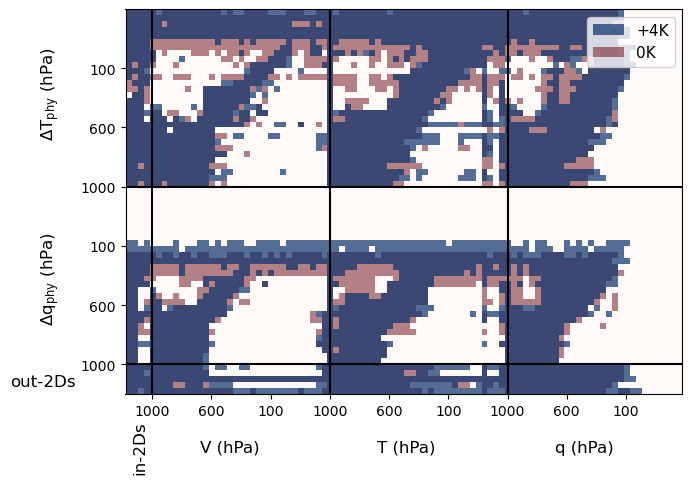

In [41]:
plot_name = "inputs_ref_plus4k_mask_net"

fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, plus4k_input_matrix,
                           second_matrix=ref_input_matrix, labels={0: "+4K", 1:"0K"}, 
                           f_name=plot_name, save=ref_output_dir)



## Overlay refernce with -4K

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/inputs/inputs_ref_minus4k_mask_net.pdf/png


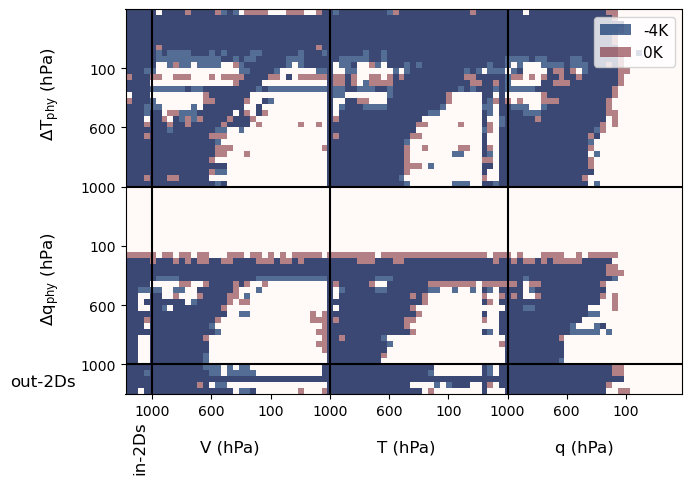

In [42]:
plot_name = "inputs_ref_minus4k_mask_net"

fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, minus4k_input_matrix,
                           second_matrix=ref_input_matrix, labels={0: "-4K", 1:"0K"}, 
                           f_name=plot_name, save=ref_output_dir)
    


## Causally-informed NN on reference climate

In [47]:
causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6") 
causal_cfg = os.path.join(causal_base_dir, "cfg_causal_single_nn_diagnostics.yml")
causal_setup = get_setup(causal_cfg)

causal_output_dir = os.path.join(causal_base_dir, "plots_offline_evaluation", "inputs")

In [50]:
with open(os.path.join(causal_base_dir, "inputs_per_var.p"), "rb") as in_file:
     c_input_idx_per_var = pickle.load(in_file)

num_inputs = len(generate_input_vars(causal_setup))
print(num_inputs)

causal_inputs_per_var = dict()

output_vars = generate_output_vars(causal_setup)
for var in output_vars:
    if str(var) == "phq-3.64" or str(var) == "phq-7.59":
        # No causal drivers were found for these variables
        continue
    causal_inputs_per_var[var] = np.zeros((num_inputs,), dtype=int)
    causal_inputs_per_var[var][c_input_idx_per_var[var]] = 1




94


In [51]:
causal_input_matrix, causal_input_inverse_idx2var, causal_output_vars_idx = \
    calculate_input_matrix(causal_setup, causal_inputs_per_var)


Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/inputs/inputs_causal_single_nn.pdf/png


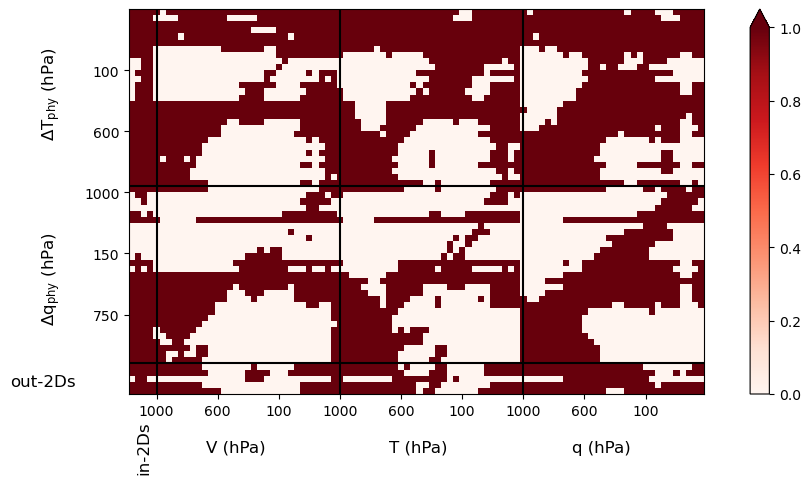

In [52]:
plot_name = "inputs_causal_single_nn"

fig, ax = plot_matrix_shap(causal_input_inverse_idx2var, causal_output_vars_idx, causal_input_matrix, 
                           cmap="Reds", f_name=plot_name, save=causal_output_dir)

# plt.savefig(os.path.join(causal_output_dir, f"{plot_name}.pdf"), format="pdf", bbox_inches="tight")
# fig.show()


## Overlay reference MaskNet with causally-informed NN

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/inputs/inputs_mask_net_causal_nn.pdf/png


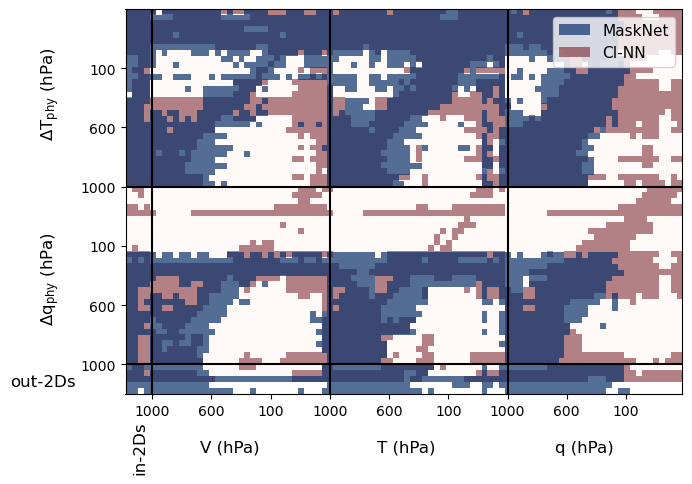

In [53]:

plot_name = "inputs_mask_net_causal_nn"

fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, ref_input_matrix,
                           second_matrix=causal_input_matrix, labels={0: "MaskNet", 1:"CI-NN"}, 
                           f_name=plot_name, save=ref_output_dir)

# plt.savefig(os.path.join(ref_output_dir, f"{plot_name}.pdf"), format="pdf", bbox_inches="tight")

# fig.show()

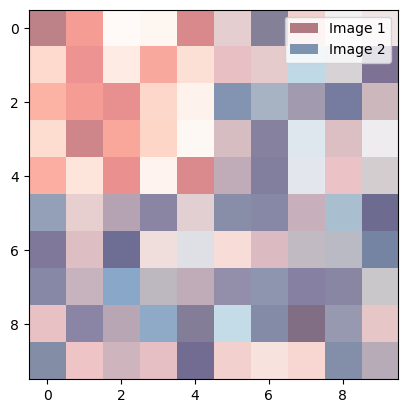

In [358]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm

# Mock data for demonstration
input_matrix = np.random.rand(10, 10)
causal_input_matrix = np.random.rand(10, 10)

# Make some values of causal_input_matrix zero for demonstration
causal_input_matrix[0:5, 0:5] = 0

# Mask zeros in the causal_input_matrix
masked_causal_matrix = ma.masked_where(causal_input_matrix == 0, causal_input_matrix)

# Create a figure and an axes
fig, ax = plt.subplots()

# Display the first image
ax.imshow(input_matrix, cmap="Reds", alpha=0.5)  # Set transparency to 50%

# Overlay the second image with masked values
ax.imshow(masked_causal_matrix, cmap="Blues", alpha=0.5)  # Set transparency to 50% and mask zeros

# Get the colors from the colormaps
red = matplotlib.cm.Reds(1.0)  # Full intensity color from Reds colormap
blue = matplotlib.cm.Blues(1.0) # Full intensity color from Blues colormap

# Adjust alpha values
red_alpha = (red[0], red[1], red[2], 0.5)  # Adding alpha to the color
blue_alpha = (blue[0], blue[1], blue[2], 0.5)  # Adding alpha to the color

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=red_alpha, edgecolor='none', label='Image 1'),
                   Patch(facecolor=blue_alpha, edgecolor='none', label='Image 2')]
ax.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()

In [89]:
metric = "abs_mean"
shap_matrix_abs_mean, input_inverse_idx2var_abs_mean, output_vars_abs_mean = calculate_shap_matrix(setup, shap_dict_per_var, metric)


In [90]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/plots


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_train/range-all_samples-1000_all/plots/SHAP_values_mask_net_0K_abs_mean_num_inputs.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


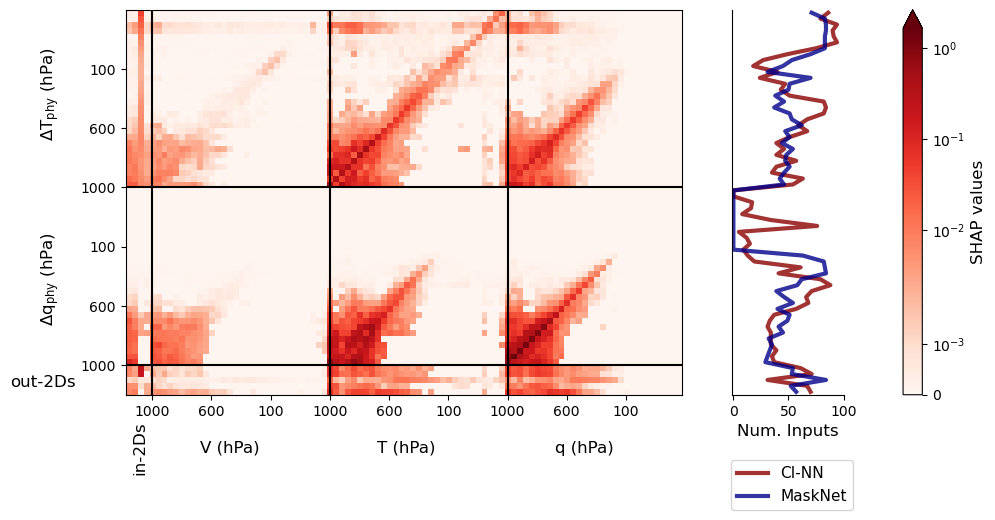

In [91]:
fig_abs_mean, ax_abs_mean = plot_matrix_shap("0K", "mask_net", metric, input_inverse_idx2var_abs_mean, output_vars_abs_mean, 
                                             shap_matrix_abs_mean, num_parents=num_inputs, save=output_dir)
plt.savefig(os.path.join(output_dir, "SHAP_values_mask_net_0K_abs_mean_num_inputs.pdf"), format="pdf", bbox_inches="tight")

fig_abs_mean.show()
